## Data Description
The dataset consists of clinical data from patients experiencing chest pain during exercise. The target variable is `output`, which indicates the likelihood of a heart attack:
- `0`: Not at risk of heart attack
- `1`: At risk of heart attack

## Data Loading and Exploration

In [45]:
# Import necessary libraries
import numpy as np
from plotnine import *
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_minimal, scale_color_manual
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, cohen_kappa_score, auc, \
    recall_score, precision_score

In [46]:
# Load the dataset
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [47]:
# Brief exploration and summary
ha.info()
ha.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


## Part One: Fitting Models

In [48]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define X and y
X = ha.drop(columns=['output'])
y = ha['output']

# Define numerical and categorical columns
numerical_columns = ['age', 'trtbps', 'chol', 'thalach']
binary_columns = ['sex']  # No need for one-hot encoding
categorical_columns = ['cp', 'restecg']  # Multiclass categories

# Define a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())  # Scale numerical features
        ]), numerical_columns),
        ('binary', 'passthrough', binary_columns),  # Pass through binary features as is
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode multiclass categories
        ]), categorical_columns)
    ]
).set_output(transform="pandas")

# Initialize Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Q1: KNN
Find the best KNN model and report cross-validated ROC AUC.

In [49]:
from sklearn.neighbors import KNeighborsClassifier

# Define KNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Define hyperparameter grid
knn_param_grid = {'knn__n_neighbors': range(1, 20)}

# Perform grid search with StratifiedKFold
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=cv, scoring='roc_auc')
knn_grid_search.fit(X, y)

# Best model and cross-validated ROC AUC
print("Best parameters for KNN:", knn_grid_search.best_params_)
print("Best cross-validated ROC AUC for KNN:", knn_grid_search.best_score_)

# Confusion matrix for the best model
best_knn_model = knn_grid_search.best_estimator_
y_pred = best_knn_model.predict(X)
print("Confusion Matrix for KNN:\n", confusion_matrix(y, y_pred))

Best parameters for KNN: {'knn__n_neighbors': 12}
Best cross-validated ROC AUC for KNN: 0.8150019451812556
Confusion Matrix for KNN:
 [[106  21]
 [ 41 105]]


### Q2: Logistic Regression
Find the best Logistic Regression model and report cross-validated ROC AUC.

In [50]:
from sklearn.linear_model import LogisticRegression

# Define Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Define hyperparameter grid
logreg_param_grid = {'logreg__C': np.logspace(-3, 3, 7)}

# Perform grid search with StratifiedKFold
logreg_grid_search = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=cv, scoring='roc_auc')
logreg_grid_search.fit(X, y)

# Best model and cross-validated ROC AUC
print("Best parameters for Logistic Regression:", logreg_grid_search.best_params_)
print("Best cross-validated ROC AUC for Logistic Regression:", logreg_grid_search.best_score_)

# Confusion matrix for the best model
best_logreg_model = logreg_grid_search.best_estimator_
y_pred = best_logreg_model.predict(X)
print("Confusion Matrix for Logistic Regression:\n", confusion_matrix(y, y_pred))

Best parameters for Logistic Regression: {'logreg__C': np.float64(1.0)}
Best cross-validated ROC AUC for Logistic Regression: 0.8578687886825819
Confusion Matrix for Logistic Regression:
 [[ 95  32]
 [ 23 123]]


### Q3: Decision Tree
Find the best Decision Tree model and report cross-validated ROC AUC.

In [51]:
from sklearn.tree import DecisionTreeClassifier

# Define numerical and categorical columns
numerical_columns = ['age', 'trtbps', 'chol', 'thalach']
categorical_columns = ['sex', 'cp', 'restecg']  # Include binary and multiclass categories

# Define a simplified column transformer for tree-based models
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),  # Pass numerical features as-is
        ('cat', 'passthrough', categorical_columns)  # Pass categorical features as-is
    ]
).set_output(transform="pandas")

# Define Decision Tree pipeline
tree_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('tree', DecisionTreeClassifier())
])

# Define hyperparameter grid
tree_param_grid = {'tree__max_depth': range(1, 20)}

# Perform grid search with StratifiedKFold
tree_grid_search = GridSearchCV(tree_pipeline, tree_param_grid, cv=cv, scoring='roc_auc')
tree_grid_search.fit(X, y)

# Best model and cross-validated ROC AUC
print("Best parameters for Decision Tree:", tree_grid_search.best_params_)
print("Best cross-validated ROC AUC for Decision Tree:", tree_grid_search.best_score_)

# Confusion matrix for the best model
best_tree_model = tree_grid_search.best_estimator_
y_pred = best_tree_model.predict(X)
print("Confusion Matrix for Decision Tree:\n", confusion_matrix(y, y_pred))

Best parameters for Decision Tree: {'tree__max_depth': 3}
Best cross-validated ROC AUC for Decision Tree: 0.8008926613616267
Confusion Matrix for Decision Tree:
 [[101  26]
 [ 26 120]]


### Q4: Interpretation
To determine which predictors were most important for predicting heart attack risk, we can use:

1. **KNN**: Permutation importance.
2. **Logistic Regression**: Coefficients (weights).
3. **Decision Tree**: Feature importances directly.

In [52]:
from sklearn.inspection import permutation_importance

# Fit the pipeline and extract transformed feature names
best_knn_model.fit(X, y)

# Permutation importance
knn_importance = permutation_importance(best_knn_model, X, y, scoring='roc_auc', n_repeats=10, random_state=42)

# Display feature importance
knn_importance_df = pd.DataFrame({
    "Feature": X.columns,  # Use pandas column names from transformed data
    "Importance": knn_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

print("KNN Feature Importance:")
print(knn_importance_df)

KNN Feature Importance:
   Feature  Importance
6  thalach    0.086191
2       cp    0.084611
1      sex    0.030695
0      age    0.030021
3   trtbps    0.013440
4     chol    0.009074
5  restecg    0.006172


In [53]:
transformed_X = best_logreg_model.named_steps['preprocessor'].transform(X)
# Extract coefficients and feature names
logreg_coef = pd.Series(
    best_logreg_model.named_steps['logreg'].coef_.flatten(),
    index=transformed_X.columns
)

# Sort and display
print("\nLogistic Regression Feature Importance:")
print(abs(logreg_coef).sort_values(ascending=False))


Logistic Regression Feature Importance:
binary__sex       1.861272
cat__cp_0         1.386929
num__thalach      0.750001
cat__cp_1         0.604197
cat__cp_2         0.485368
num__trtbps       0.316501
cat__cp_3         0.299432
cat__restecg_1    0.289283
num__chol         0.257636
cat__restecg_2    0.241299
num__age          0.223183
cat__restecg_0    0.045916
dtype: float64


In [54]:
# Extract feature importances from the tree
transformed_X = best_tree_model.named_steps['preprocessor'].transform(X)
tree_importances = pd.Series(
    best_tree_model.named_steps['tree'].feature_importances_,
    index=transformed_X.columns
)

# Sort and display
print("\nDecision Tree Feature Importance:")
print(tree_importances.sort_values(ascending=False))


Decision Tree Feature Importance:
cat__cp         0.564630
num__age        0.151122
num__thalach    0.112866
cat__sex        0.099147
num__trtbps     0.072235
num__chol       0.000000
cat__restecg    0.000000
dtype: float64


The feature importance results from the KNN model indicate that `thalach` (maximum heart rate achieved during exercise) is the most influential predictor, followed closely by `cp` (chest pain type). These features demonstrate strong relationships with heart attack risk as identified by the model's reliance on distance metrics, which prioritize features with higher variability or stronger signals. Other predictors, such as `sex` and `age`, exhibit moderate importance, while `trtbps` (resting blood pressure), `chol` (cholesterol levels), and `restecg` (resting electrocardiographic results) have minimal impact. This suggests that KNN primarily captures patterns associated with dynamic exercise-induced physiological responses rather than static clinical measures.

In logistic regression, the magnitude of coefficients underscores the importance of `sex` and chest pain categories. `sex` has the highest coefficient magnitude, indicating a significant impact on heart attack risk. Among chest pain types, asymptomatic pain (`cp_0`) and typical angina (`cp_1`) are particularly important, followed by other subtypes. The numerical predictor `thalach` also ranks highly, reinforcing its relevance across models. Meanwhile, features such as `trtbps`, `chol`, and `age` exhibit moderate importance, reflecting their steady but less dominant influence. The categorical variables from `restecg` (resting electrocardiographic results) play a smaller role, consistent with their weaker signal in the dataset.

The decision tree model emphasizes `cp` as the most critical predictor, capturing over half of the total feature importance. This aligns with the tree’s capacity to partition the data effectively based on chest pain type, which appears to be a strong categorical discriminator. Among numerical features, `age` and `thalach` rank next in importance, while `sex` provides a smaller but meaningful contribution. Interestingly, `chol` and `restecg` have no importance in the tree model, suggesting that these variables do not enhance the tree’s ability to reduce impurity during splits. This highlights the decision tree's reliance on features with clear, threshold-based splits over those with subtler or more continuous effects.

### Q5: ROC Curve

Plot the ROC Curve for your three models above.

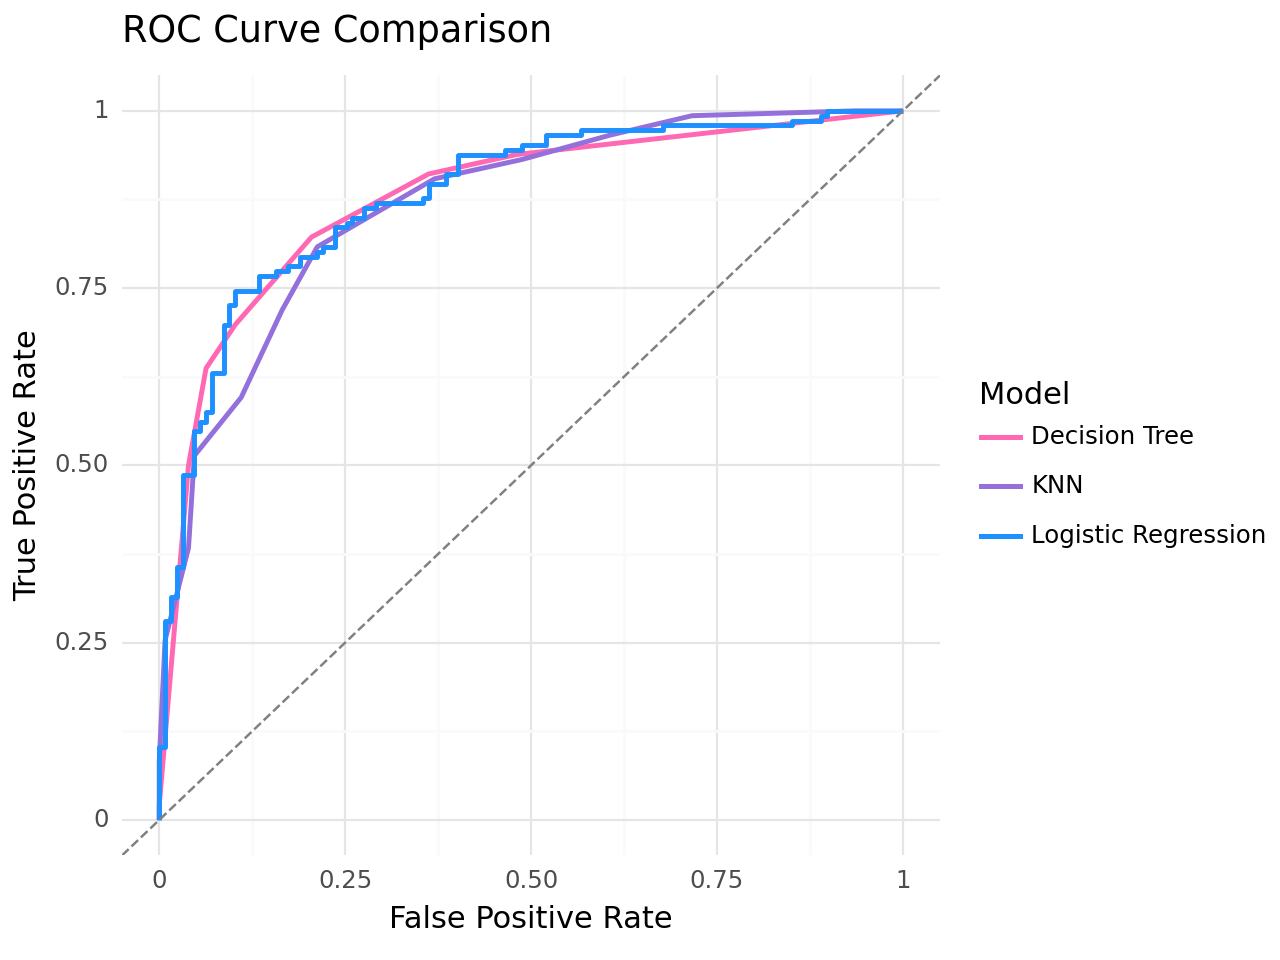

In [55]:
# Prepare data for ROC curves
roc_data = []

models = [best_knn_model, best_logreg_model, best_tree_model]
model_names = ['KNN', 'Logistic Regression', 'Decision Tree']

for model, name in zip(models, model_names):
    y_pred_prob = model.predict_proba(X)[:, 1]  # Probabilities for class 1
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    roc_data.append(pd.DataFrame({
        'False Positive Rate': fpr,
        'True Positive Rate': tpr,
        'Model': name,
        'AUC': roc_auc
    }))

# Combine all ROC data
roc_df = pd.concat(roc_data)

# Plot the ROC Curve using plotnine
roc_plot = (
    ggplot(roc_df, aes(x='False Positive Rate', y='True Positive Rate', color='Model')) +
    geom_line(size=1) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='gray') +  # Random guess line
    labs(
        title='ROC Curve Comparison',
        x='False Positive Rate',
        y='True Positive Rate',
        color='Model'
    ) +
    theme_minimal() +
    scale_color_manual(values=["#ff69b4", "#9370db", "#1e90ff"])  # Pink, Purple, Blue
)

print(roc_plot)

# Part Two: Metrics

Consider the following metrics:

- True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

- Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

- True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

---
Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [56]:
# Function to compute cross-validated metrics
def compute_metrics_cv(model, X, y, cv):
    # Perform cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=cv)
    
    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Compute metrics
    sensitivity = recall_score(y, y_pred)  # Recall or True Positive Rate
    precision = precision_score(y, y_pred)  # Positive Predictive Value
    specificity = tn / (tn + fp)  # True Negative Rate
    
    return sensitivity, precision, specificity

# Models
models = [best_knn_model, best_logreg_model, best_tree_model]
model_names = ['KNN', 'Logistic Regression', 'Decision Tree']

# Compute and display metrics for each model
for model, name in zip(models, model_names):
    sensitivity, precision, specificity = compute_metrics_cv(model, X, y, cv)
    print(f"{name} Metrics:")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Specificity: {specificity:.4f}\n")

KNN Metrics:
  Sensitivity (Recall): 0.6438
  Precision: 0.8034
  Specificity: 0.8189

Logistic Regression Metrics:
  Sensitivity (Recall): 0.8219
  Precision: 0.7742
  Specificity: 0.7244

Decision Tree Metrics:
  Sensitivity (Recall): 0.6781
  Precision: 0.7857
  Specificity: 0.7874



The KNN model shows moderate performance, with a strong **specificity** (0.8189) and high **precision** (0.8034), indicating it is effective at correctly identifying negative cases and minimizing false positives. However, its lower **sensitivity** (0.6438) suggests it struggles to identify true positives, which could be problematic in high-risk scenarios.

The Logistic Regression model excels in **sensitivity** (0.8219), making it the best at detecting true positives among the models. However, it has lower **specificity** (0.7244), which means it generates more false positives compared to KNN and the Decision Tree. Its **precision** (0.7742) balances its ability to correctly classify positives.

The Decision Tree model balances **specificity** (0.7874) and **precision** (0.7857), performing similarly to KNN in these metrics. Its **sensitivity** (0.6781) is slightly better than KNN but not as high as Logistic Regression, indicating a more balanced but less specialized performance.

# Part Three: Discussion
Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

- Which metric(s) you would use for model selection and why.

- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

- What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

### Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

Metric(s): Sensitivity (Recall) is the most critical metric since it measures the proportion of true positives (high-risk patients) that the model correctly identifies. Missing a high-risk patient could lead to severe consequences, so false negatives must be minimized.

Recommended Model: Logistic Regression is the best choice due to its high sensitivity (0.8219), which ensures most high-risk patients are identified.

Expected Score: With Logistic Regression, sensitivity is expected to be around 0.82 for future predictions, though specificity and precision may be lower due to the trade-off of reducing false negatives.

### Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

Metric(s): Precision is key because the hospital wants to prioritize patients most likely to truly be high-risk. A higher precision ensures that a greater proportion of flagged high-risk patients genuinely require monitoring, minimizing unnecessary use of resources.

Recommended Model: KNN is the best choice due to its high precision (0.8034), ensuring that flagged patients are highly likely to be genuinely at risk.

Expected Score: Precision is expected to be around 0.80 for KNN, providing a strong ability to reduce false positives and optimize resource allocation effectively.

### Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

Metric(s): Interpretability is critical here, so a model that allows for easy understanding of feature importance is essential. Logistic Regression, with its interpretable coefficients, is ideal for identifying significant predictors of heart attack risk.

Recommended Model: Logistic Regression is the best choice, as its coefficients directly indicate the strength and direction of the relationship between predictors and heart attack risk.

Expected Score: Sensitivity (0.8219) and precision (0.7742) reflect the model’s ability to accurately classify and explain the role of biological predictors like chest pain type (cp) and heart rate (thalach).

### Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

Metric(s): Overall performance balance, represented by metrics like specificity and precision, is important for a fair comparison between the model and new doctors. Specificity ensures accurate predictions for low-risk patients, while precision highlights correct positive classifications.

Recommended Model: Decision Tree is a good choice due to its balanced sensitivity (0.6781), precision (0.7857), and specificity (0.7874). Additionally, its transparent structure makes it easy to explain to trainees.

Expected Score: With the Decision Tree, specificity and precision are expected to be approximately 0.78, providing a balanced model for comparison and interpretability.

In [57]:
# Load the validation dataset
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

# Separate features and target variable
X_val = ha_validation.drop(columns=['output'])
y_val = ha_validation['output']

# Function to evaluate models on the validation set
def evaluate_model_on_validation(model, X_val, y_val):
    # Predict probabilities and class labels
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    auc = roc_auc_score(y_val, y_pred_prob)
    cm = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    return auc, cm, precision, recall

# Models and their names
models = [best_knn_model, best_logreg_model, best_tree_model]
model_names = ['KNN', 'Logistic Regression', 'Decision Tree']

# Evaluate each model and display results
for model, name in zip(models, model_names):
    auc, cm, precision, recall = evaluate_model_on_validation(model, X_val, y_val)
    print(f"{name} Validation Metrics:")
    print(f"  ROC AUC: {auc:.4f}")
    print(f"  Confusion Matrix:\n{cm}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall (Sensitivity): {recall:.4f}\n")


KNN Validation Metrics:
  ROC AUC: 0.7990
  Confusion Matrix:
[[ 9  2]
 [ 8 11]]
  Precision: 0.8462
  Recall (Sensitivity): 0.5789

Logistic Regression Validation Metrics:
  ROC AUC: 0.8995
  Confusion Matrix:
[[ 9  2]
 [ 5 14]]
  Precision: 0.8750
  Recall (Sensitivity): 0.7368

Decision Tree Validation Metrics:
  ROC AUC: 0.7775
  Confusion Matrix:
[[ 8  3]
 [ 7 12]]
  Precision: 0.8000
  Recall (Sensitivity): 0.6316



For **KNN**, the validation ROC AUC (0.7990) is slightly lower than its cross-validated score, but the decrease is modest, indicating reasonable generalization. However, its precision (0.8462) and recall (0.5789) diverge from the cross-validation estimates, showing that while it maintains its ability to minimize false positives, its sensitivity drops, making it less reliable in detecting true positives in the validation set.

**Logistic Regression** demonstrates the strongest performance on the validation set, with an impressive ROC AUC (0.8995), closely matching its cross-validated estimate. Its precision (0.8750) and recall (0.7368) are consistent with its earlier performance, confirming its ability to balance sensitivity and specificity effectively. This suggests Logistic Regression generalizes well to unseen data and aligns closely with the cross-validated metrics, supporting its suitability for scenarios prioritizing high recall and interpretability.

For the **Decision Tree**, the validation ROC AUC (0.7775) is close to its cross-validated score, indicating stable performance. Its precision (0.8000) and recall (0.6316) reflect a balanced approach but slightly lower sensitivity compared to cross-validation. This indicates that while the Decision Tree maintains its ability to identify true positives and avoid false positives, its generalization to unseen data is less robust than Logistic Regression. These results align with its tendency to overfit slightly to the training data due to its reliance on exact splits.

# Part Five: Cohen’s Kappa

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

Sources used:
- https://builtin.com/data-science/cohens-kappa
- https://scikit-learn.org/dev/modules/generated/sklearn.metrics.cohen_kappa_score.html

In [58]:
from sklearn.metrics import cohen_kappa_score

# Function to compute Cohen's Kappa for a model
def compute_cohens_kappa(model, X, y):
    y_pred = model.predict(X)  # Predicted classes
    return cohen_kappa_score(y, y_pred)

# Calculate Cohen's Kappa for each model
for model, name in zip(models, model_names):
    kappa = compute_cohens_kappa(model, X_val, y_val)
    print(f"{name} Cohen's Kappa: {kappa:.4f}")

KNN Cohen's Kappa: 0.3562
Logistic Regression Cohen's Kappa: 0.5249
Decision Tree Cohen's Kappa: 0.3333


Logistic Regression achieves the highest Kappa (0.5249), indicating moderate agreement with true labels and validating its strong overall performance observed in earlier metrics like ROC AUC and sensitivity. KNN and the Decision Tree have lower Kappa values (0.3562 and 0.3333, respectively), reflecting weaker agreement. This is consistent with their lower sensitivity and more limited ability to generalize effectively compared to Logistic Regression. The Decision Tree’s slightly lower Kappa than KNN suggests its performance is more heavily influenced by overfitting to the training data.

Cohen’s Kappa is particularly useful in scenarios where class imbalance is present or when chance agreement could skew raw accuracy metrics. In this dataset, if the proportion of low-risk and high-risk patients were uneven( 1:146
0:127), Kappa would provide a more meaningful assessment by correcting for the likelihood of random agreement. For healthcare applications, where false negatives and false positives have different consequences, Kappa ensures the evaluation reflects the model’s actual agreement with true classifications, rather than being biased by the dominant class.

The conclusions remain consistent when using Cohen’s Kappa as a primary metric. Logistic Regression still emerges as the strongest model, balancing sensitivity, precision, and agreement with true labels. KNN and the Decision Tree perform less effectively, with Kappa values that align with their previously observed limitations in sensitivity and generalization. This consistency supports the validity of using Cohen’s Kappa to reinforce the earlier findings, while also highlighting its value as a robust metric for comparing models in settings where random agreement and class imbalance are concerns.